In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
import pytorch_lightning as pl
import pandas as pd
from PIL import Image
from sklearn import metrics

In [3]:
import cv2
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Define Model

In [4]:
class Classifier(pl.LightningModule):
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = models.resnet18(pretrained=False)
        # change 1st conv layer from 3 channel to 1 channel
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        #change to single output
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)
        self.BCELoss = nn.BCEWithLogitsLoss()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        return optimizer
    
    def BCE_loss(self, logits, labels):
        return self.BCELoss(logits, labels.float())
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)   # we already defined forward and loss in the lightning module. We'll show the full code next
        logits = torch.flatten(logits)
        loss = self.BCE_loss(logits, y)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        logits = torch.flatten(logits)
        loss = self.BCE_loss(logits, y)
        self.log('val_loss', loss)
        
    def predict(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x

In [20]:
class CXRDataset(Dataset):
    def __init__(self, excel_path : str = "./", img_dir : str = "./",
                 img_brt_std : float = 0.10448302):
        """
        Args:
            excel_path (string): Path to excel file with ids and labels.
            img_dir (string): Directory with all the png images.
            img_brt_std (float): Standard deviation of brightness of training dataset.
        """
        self.dataset = self.prepare_dataset(excel_path)
        self.img_dir = img_dir
        self.img_brt_std = img_brt_std
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        
    def prepare_dataset(self, excel_path):
        df = pd.read_excel(excel_path)
        df = df.sort_values(by='Abnormal', ascending=False)
        df = df.drop_duplicates(subset="image_id", keep="first")
        df = df.sample(frac=1).reset_index(drop=True)
        return df
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.dataset['image_id'].iloc[idx] + '.png')
        image = Image.open(img_path)
        image = self.transform(image)
        label = self.dataset['Nodule/Mass'].iloc[idx]
        uuid = self.dataset['image_id'].iloc[idx]
        return image, label

In [21]:
class DataModule(pl.LightningDataModule):
    def __init__(self, img_dir: str = "./", train_file: str = "./",
                 val_file:str="./", batch_size: int = 24, num_workers: int = 0):
        """
        Args:
            img_dir (string): Directory with all the png images.
            train_file (string): path to train image excel
            val_file (string): path to validation image excel
            batch_size (int): batch size for training
        """
        super().__init__()
        self.img_dir = img_dir
        self.train_file = train_file
        self.val_file = val_file
        self.batch_size = batch_size
        self.num_workers = num_workers
    
    def prepare_data(self):
        self.train_data = CXRDataset(self.train_file, self.img_dir)
        self.val_data = CXRDataset(self.val_file, self.img_dir)
        
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size,
                         num_workers=self.num_workers)
        

## Train Model

In [29]:
dataset = DataModule('imgs/', './train.xlsx', './test.xlsx')
dataset.prepare_data()

In [30]:
model = Classifier()

In [31]:
trainer = pl.Trainer(checkpoint_callback=False, max_epochs=8)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [32]:
trainer.fit(model, dataset.train_dataloader(), dataset.val_dataloader())
trainer.save_checkpoint("models/node_base_model.ckpt")


  | Name    | Type              | Params
----------------------------------------------
0 | model   | ResNet            | 11.2 M
1 | BCELoss | BCEWithLogitsLoss | 0     
2 | sigmoid | Sigmoid           | 0     
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Epoch 0:  83%|████████▎ | 417/501 [50:41<10:11,  7.28s/it, loss=0.222, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  83%|████████▎ | 417/501 [29:56<06:01,  4.30s/it, loss=0.212, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  83%|████████▎ | 417/501 [26:33<05:20,  3.81s/it, loss=0.204, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  83%|████████▎ | 417/501 [29:43<05:58,  4.27s/it, loss=0.197, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 4:  83%|████████▎ | 417/501 [28:54<05:48,  4.15s/it, loss=0.189, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  83%|████████▎ | 417/501 [28:29<05:43,  4.09s/it, loss=0.184, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  83%|████████▎ | 418/501 [27:30<05:26,  3.94s/it, loss=0.178, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  83%|████████▎ | 418/501 [27:32<05:27,  3.95s/it, loss=0.174, v_num=8] 
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 501/501 [29:28<00:00,  3.52s/it, loss=0.174, v_num=8]


## Evaluate Model

In [33]:
def validate(model, val_loader):
    labels = []
    pred_list = []
    for x, y in val_loader:
        #x = x.to(device)
        preds = model.predict(x)
        labels += list(y.detach().cpu().numpy())
        pred_list += list(preds.detach().cpu().numpy())
    return labels, pred_list

In [34]:
labels, pred_list = validate(model, dataset.val_dataloader())

In [65]:
def analysis(labels, pred_list, threshold : float = 0.5):
    results = {}
    results['fpr'], results['tpr'], results['thresholds'] = metrics.roc_curve(labels, pred_list)
    results['auc'] = metrics.auc(results['fpr'], results['tpr'])
    
    pred_class_list = []
    for logit in pred_list:
        if logit >= threshold:
            pred_class = 1
        else:
            pred_class = 0
        pred_class_list.append(pred_class)
    
    prfs = metrics.precision_recall_fscore_support(labels, pred_class_list)
    results['precision'], results['recall'], results['fscore'], results['support'] = prfs
    
    results['confusion_matrix'] = metrics.confusion_matrix(labels, pred_class_list)
    
    return results

def plot_confusion_matrix(confusion_matrix):
    
    ax = plt.subplot()
    sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Normal', 'Nodule/Mass']); ax.yaxis.set_ticklabels(['Normal', 'Nodule/Mass']);


In [75]:
results = analysis(labels, pred_list)

In [67]:
results['auc']

0.7954178293435159

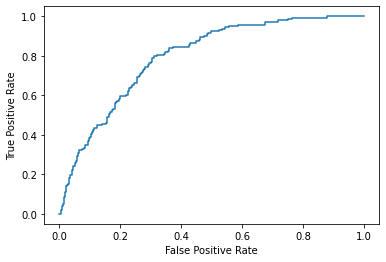

In [68]:
roc_curve = metrics.RocCurveDisplay(fpr=results['fpr'], tpr=results['tpr'])
roc_curve.plot()
plt.show()

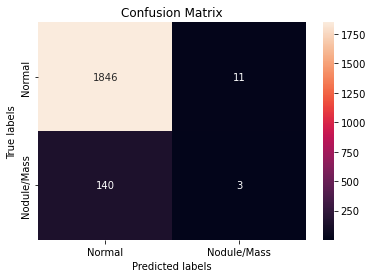

In [69]:
plot_confusion_matrix(results['confusion_matrix'])

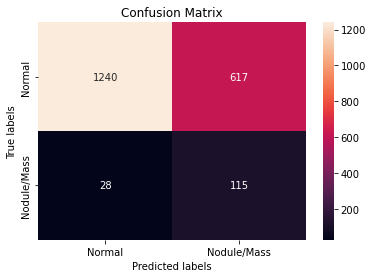

In [97]:
results = analysis(labels, pred_list, threshold=0.04, f_beta=3)
plot_confusion_matrix(results['confusion_matrix'])

In [98]:
results['auc']

0.7954178293435159

In [99]:
results['precision']

array([0.97791798, 0.15710383])

In [100]:
results['recall']

array([0.66774367, 0.8041958 ])

In [101]:
results['fscore']

array([0.68961682, 0.56958891])

In [57]:
results['support']

array([1857,  143])

In [88]:
def analysis(labels: list, pred_list: list, threshold: float = 0.5, f_beta: float = 1):
    """ Analyses model performance and returns a variety of metrics
    Args:
        labels (list) : list of binary integer labels
        pred_list (list) : list of prediction logits
        threshold (float) : threshold to define decision boundary
        f_beta (float) : weighting of recall vs precision in f score
    """
    results = {}
    results['fpr'], results['tpr'], results['thresholds'] = metrics.roc_curve(labels, pred_list)
    results['auc'] = metrics.auc(results['fpr'], results['tpr'])
    
    
    ################ ADDED IN CALCULATIONS FOR RECALL, PRECISION, FSCORE AND CONFUSION MATRIX
    pred_class_list = []
    for logit in pred_list:
        if logit >= threshold:
            pred_class = 1
        else:
            pred_class = 0
        pred_class_list.append(pred_class)
    
    prfs = metrics.precision_recall_fscore_support(labels, pred_class_list, beta=f_beta)
    results['precision'], results['recall'], results['fscore'], results['support'] = prfs
    
    results['confusion_matrix'] = metrics.confusion_matrix(labels, pred_class_list)
    
    return results

In [ ]:
    results = analysis(labels, pred_list, threshold=threshold, f_beta=3)


In [89]:
f_scores = []
threshold_range = np.arange(0,1,0.01)
for threshold in threshold_range:
    results = analysis(labels, pred_list, threshold=threshold, f_beta=3)
    f_scores.append(results['fscore'][1])

recall_weighted_threshold = threshold_range[np.array(f_scores).argmax()]
print('Recall weighted threshold: ', recall_weighted_threshold)


/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall weighted threshold:  0.04


/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maia/miniforge3/envs/pytorch-lightning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [ ]:
dataset.train_data.dataset.groupby(['Nodule/Mass', 'Abnormal']).count()

## Experiments

### Brightness